<a href="https://colab.research.google.com/github/chihina/gan-mnist-python/blob/master/simple_gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train simple GAN for MNIST

### Import library


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchvision.utils import save_image

import random
from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

##Define network

In [25]:
class Generator(torch.nn.Module):
    def __init__(self, latent_dim, mnist_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(latent_dim, 256, bias=False)
        self.fc2 = torch.nn.Linear(256, 512, bias=False)
        self.fc3 = torch.nn.Linear(512, mnist_size, bias=False)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

class Discriminator(torch.nn.Module):
    def __init__(self, class_num):
        super().__init__()

        self.conv_block = nn.Sequential(
             nn.Conv2d(1, 2, kernel_size=3, padding=1),
             nn.ReLU(),
             nn.Conv2d(2, 4, kernel_size=3, padding=1),
             nn.ReLU(),
             nn.MaxPool2d((2, 2)),
             nn.Conv2d(4, 8, kernel_size=3, padding=1),
             nn.ReLU(),
             nn.Conv2d(8, 16, kernel_size=3, padding=1),
             nn.ReLU(),

             nn.Conv2d(16, class_num, kernel_size=1),
             nn.AvgPool2d((14, 14)),
             nn.Flatten(),
        )

        self.sigmooid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_block(x)
        x = self.sigmooid(x)

        return x

## Define train function

In [26]:
def train(epoch):
    G_losses = 0
    D_losses = 0

    netD.train()
    netG.train()

    for data in tqdm(trainloader):
        img, label_mnist = data[0], data[1]
        label = torch.full((img.shape[0],), real_label, dtype=torch.float, device=device)
        
        img = img.to(device)
        label = label.to(device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch

        # Forward pass real batch through D
        output = netD(img).view(-1)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        netD.zero_grad()
        errD_real.backward()

        ## Train with all-fake batch
        
        # Generate batch of latent vectors
        noise = torch.randn(img.shape[0], latent_dim, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        fake = fake.view(img.shape[0], 1, int(mnist_size**0.5), int(mnist_size**0.5))
        output = netD(fake.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses += errG.item()
        D_losses += errD.item()

    G_losses_epoch = G_losses / len(trainloader)
    D_losses_epoch = D_losses / len(trainloader)

    return G_losses_epoch, D_losses_epoch

## Define valid function

In [37]:
def valid(epoch_num):
    G_losses = 0
    D_losses = 0

    netD.eval()
    netG.eval()

    for data in tqdm(testloader):
        img, label_mnist = data[0], data[1]
        label = torch.full((img.shape[0],), real_label, dtype=torch.float, device=device)

        img = img.to(device)
        label = label.to(device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch

        # Forward pass real batch through D
        output = netD(img).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for D in backward pass
        netD.zero_grad()
        errD_real.backward()

        ## Train with all-fake batch

        # Generate batch of latent vectors
        noise = torch.randn(img.shape[0], latent_dim, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        fake = fake.view(img.shape[0], 1, int(mnist_size**0.5), int(mnist_size**0.5))
        output = netD(fake.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        # optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        # optimizerG.step()

        # Save Losses for plotting later
        G_losses += errG.item()
        D_losses += errD.item()

    G_losses_epoch = G_losses / len(testloader)
    D_losses_epoch = D_losses / len(testloader)

    return G_losses_epoch, D_losses_epoch

## Run training and validation

In [44]:
# seed
torch.manual_seed(777)

# define parameters
latent_dim = 64
mnist_size = 28 * 28
batch_size = 32
lr = 0.001
epoch_all = 20

# for gpu
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# generate model instances
netD = Discriminator(1)
netG = Generator(latent_dim, mnist_size)

# move to GPU
netD = netD.to(device)
netG = netG.to(device)

# Setup Adam optimizers for generator and discriminator
optimizerD = optim.Adam(netD.parameters(), lr=lr)
optimizerG = optim.Adam(netG.parameters(), lr=lr)

# Initialize CrossEntoropy function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=batch_size,
                                            shuffle=False, 
                                            num_workers=2)

G_losses_array = np.zeros((2, epoch_all))
D_losses_array = np.zeros((2, epoch_all))

best_loss = 10000

for epoch_num in range(1, epoch_all+1):

    G_losses_epoch_train, D_losses_epoch_train = train(epoch_num)
    print(f'Train, Epoch:{epoch_num}/{epoch_all}, G_loss:{G_losses_epoch_train:.5f}, D_loss:{D_losses_epoch_train:.5f}')
    
    G_losses_epoch_valid, D_losses_epoch_valid = valid(epoch_num)
    print(f'Valid, Epoch:{epoch_num}/{epoch_all}, G_loss:{G_losses_epoch_valid:.5f}, D_loss:{D_losses_epoch_valid:.5f}')

    G_losses_array[0, epoch_num-1] = G_losses_epoch_train
    D_losses_array[0, epoch_num-1] = D_losses_epoch_train
    G_losses_array[1, epoch_num-1] = G_losses_epoch_valid
    D_losses_array[1, epoch_num-1] = D_losses_epoch_valid

    valid_loss_all = G_losses_epoch_valid + D_losses_epoch_valid
    if best_loss > valid_loss_all:
      best_loss = valid_loss_all
      print(f'Best loss, save {epoch_num} epoch')
      torch.save(netD.state_dict(), 'netD_weight.pth')
      torch.save(netG.state_dict(), 'netG_weight.pth')
    if epoch_num == epoch_all:
      torch.save(netD.state_dict(), 'netD_weight_final.pth')
      torch.save(netG.state_dict(), 'netG_weight_final.pth')   

100%|██████████| 1875/1875 [00:47<00:00, 39.17it/s]


Train, Epoch:1/20, G_loss:1.06024, D_loss:1.26451


100%|██████████| 313/313 [00:06<00:00, 45.27it/s]


Valid, Epoch:1/20, G_loss:0.73237, D_loss:1.44450
Best loss, save 1 epoch


100%|██████████| 1875/1875 [00:43<00:00, 43.21it/s]


Train, Epoch:2/20, G_loss:0.69425, D_loss:1.39543


100%|██████████| 313/313 [00:06<00:00, 46.15it/s]


Valid, Epoch:2/20, G_loss:0.71059, D_loss:1.38448
Best loss, save 2 epoch


100%|██████████| 1875/1875 [00:42<00:00, 43.85it/s]


Train, Epoch:3/20, G_loss:0.69037, D_loss:1.38827


100%|██████████| 313/313 [00:06<00:00, 47.35it/s]


Valid, Epoch:3/20, G_loss:0.70158, D_loss:1.38874
Best loss, save 3 epoch


100%|██████████| 1875/1875 [00:44<00:00, 41.79it/s]


Train, Epoch:4/20, G_loss:0.69301, D_loss:1.38705


100%|██████████| 313/313 [00:07<00:00, 43.91it/s]


Valid, Epoch:4/20, G_loss:0.68636, D_loss:1.38823
Best loss, save 4 epoch


100%|██████████| 1875/1875 [00:45<00:00, 40.99it/s]


Train, Epoch:5/20, G_loss:0.69304, D_loss:1.38669


100%|██████████| 313/313 [00:06<00:00, 45.30it/s]


Valid, Epoch:5/20, G_loss:0.70954, D_loss:1.38530


100%|██████████| 1875/1875 [00:44<00:00, 42.22it/s]


Train, Epoch:6/20, G_loss:1.03555, D_loss:1.14779


100%|██████████| 313/313 [00:06<00:00, 44.82it/s]


Valid, Epoch:6/20, G_loss:1.77611, D_loss:0.49722


100%|██████████| 1875/1875 [00:45<00:00, 41.04it/s]


Train, Epoch:7/20, G_loss:1.38755, D_loss:0.77984


100%|██████████| 313/313 [00:06<00:00, 44.97it/s]


Valid, Epoch:7/20, G_loss:2.17521, D_loss:0.77332


100%|██████████| 1875/1875 [00:43<00:00, 43.19it/s]


Train, Epoch:8/20, G_loss:1.43944, D_loss:0.79155


100%|██████████| 313/313 [00:06<00:00, 47.30it/s]


Valid, Epoch:8/20, G_loss:1.25485, D_loss:0.76047
Best loss, save 8 epoch


100%|██████████| 1875/1875 [00:44<00:00, 41.90it/s]


Train, Epoch:9/20, G_loss:1.69528, D_loss:0.56128


100%|██████████| 313/313 [00:06<00:00, 45.87it/s]


Valid, Epoch:9/20, G_loss:1.93919, D_loss:0.35232


100%|██████████| 1875/1875 [00:45<00:00, 41.34it/s]


Train, Epoch:10/20, G_loss:2.09726, D_loss:0.40106


100%|██████████| 313/313 [00:06<00:00, 44.94it/s]


Valid, Epoch:10/20, G_loss:2.77399, D_loss:0.30157


100%|██████████| 1875/1875 [00:44<00:00, 42.37it/s]


Train, Epoch:11/20, G_loss:2.61117, D_loss:0.29770


100%|██████████| 313/313 [00:06<00:00, 47.13it/s]


Valid, Epoch:11/20, G_loss:2.04626, D_loss:0.26247


100%|██████████| 1875/1875 [00:43<00:00, 43.30it/s]


Train, Epoch:12/20, G_loss:2.99053, D_loss:0.19755


100%|██████████| 313/313 [00:06<00:00, 44.93it/s]


Valid, Epoch:12/20, G_loss:3.79829, D_loss:0.24754


100%|██████████| 1875/1875 [00:44<00:00, 41.97it/s]


Train, Epoch:13/20, G_loss:2.87014, D_loss:0.32891


100%|██████████| 313/313 [00:07<00:00, 44.28it/s]


Valid, Epoch:13/20, G_loss:3.53215, D_loss:0.25245


100%|██████████| 1875/1875 [00:44<00:00, 41.78it/s]


Train, Epoch:14/20, G_loss:3.13627, D_loss:0.27623


100%|██████████| 313/313 [00:06<00:00, 46.14it/s]


Valid, Epoch:14/20, G_loss:5.16431, D_loss:0.52751


100%|██████████| 1875/1875 [00:43<00:00, 43.02it/s]


Train, Epoch:15/20, G_loss:2.98905, D_loss:0.33622


100%|██████████| 313/313 [00:06<00:00, 46.17it/s]


Valid, Epoch:15/20, G_loss:2.09331, D_loss:0.30859


100%|██████████| 1875/1875 [00:43<00:00, 42.89it/s]


Train, Epoch:16/20, G_loss:3.09967, D_loss:0.25591


100%|██████████| 313/313 [00:06<00:00, 47.18it/s]


Valid, Epoch:16/20, G_loss:3.56333, D_loss:0.32319


100%|██████████| 1875/1875 [00:42<00:00, 43.68it/s]


Train, Epoch:17/20, G_loss:2.99689, D_loss:0.31819


100%|██████████| 313/313 [00:06<00:00, 47.07it/s]


Valid, Epoch:17/20, G_loss:3.34885, D_loss:0.15221


100%|██████████| 1875/1875 [00:43<00:00, 43.20it/s]


Train, Epoch:18/20, G_loss:3.30850, D_loss:0.26303


100%|██████████| 313/313 [00:06<00:00, 45.58it/s]


Valid, Epoch:18/20, G_loss:2.52640, D_loss:0.18690


100%|██████████| 1875/1875 [00:44<00:00, 42.59it/s]


Train, Epoch:19/20, G_loss:3.23316, D_loss:0.21873


100%|██████████| 313/313 [00:07<00:00, 44.61it/s]


Valid, Epoch:19/20, G_loss:4.47049, D_loss:0.11102


100%|██████████| 1875/1875 [00:43<00:00, 43.05it/s]


Train, Epoch:20/20, G_loss:3.43260, D_loss:0.24659


100%|██████████| 313/313 [00:06<00:00, 45.77it/s]

Valid, Epoch:20/20, G_loss:1.01617, D_loss:0.89138
Best loss, save 20 epoch


## Visualize loss curves

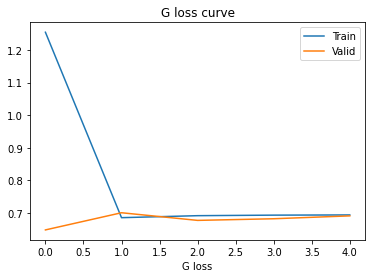

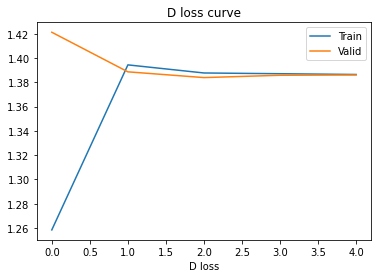

In [39]:
plt.figure()
plt.plot(np.arange(epoch_num), G_losses_array[0, :], label='Train')
plt.plot(np.arange(epoch_num), G_losses_array[1, :], label='Valid')
plt.title('G loss curve')
plt.xlabel('Epoch num')
plt.xlabel('G loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.arange(epoch_num), D_losses_array[0, :], label='Train')
plt.plot(np.arange(epoch_num), D_losses_array[1, :], label='Valid')
plt.title('D loss curve')
plt.xlabel('Epoch num')
plt.xlabel('D loss')
plt.legend()
plt.show()

# Generate image using trained model

Random noise torch.Size([1, 64])
Generated img torch.Size([1, 1, 28, 28])


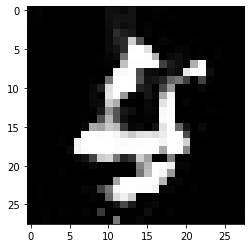

In [45]:
from PIL import Image

# generate model instances
netG = Generator(latent_dim, mnist_size)
netG.load_state_dict(torch.load('netG_weight.pth', map_location=device))

# move to GPU
netG = netG.to(device)

# generate noise sample
noise = torch.randn(1, latent_dim, device=device)
print('Random noise', noise.shape)
generated_img = netG(noise)
generated_img = generated_img.view(1, 1, int(mnist_size**0.5), int(mnist_size**0.5))
print('Generated img', generated_img.shape)

# save generated image
save_image(generated_img, f'generated_img.png')
generated_img = Image.open("generated_img.png")
generated_img = np.asarray(generated_img)
plt.imshow(generated_img)
plt.show()